In [213]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing



[[0 1 1 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 0 0]
 [0 0 1 0 0 1 0 1 0]
 [0 0 1 0 0 0 1 0 1]
 [0 0 0 1 0 1 0 0 0]
 [0 0 0 0 1 0 1 0 0]
 [0 0 0 1 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 1]]


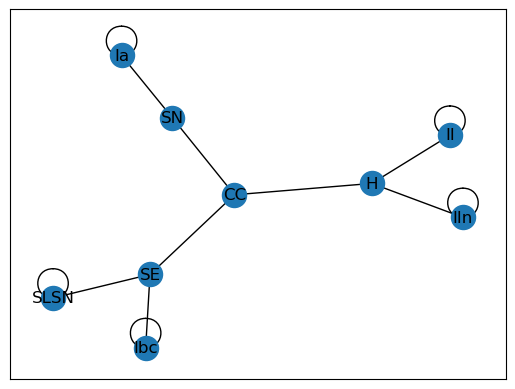

In [149]:
# Make a graph
vertices = ['SN', 'Ia', 'CC', 'H', 'SE', 'II', 'Ibc', 'IIn', 'SLSN']
G=nx.Graph()
G.add_edge('SN','Ia')
G.add_edge('SN','CC')
G.add_edge('CC','H')
G.add_edge('CC','SE')
G.add_edge('H','II')
G.add_edge('H','IIn')
G.add_edge('SE','Ibc')
G.add_edge('SE','SLSN')

# Add edges to lowest leaves
G.add_edge('Ia','Ia')
G.add_edge('Ibc','Ibc')
G.add_edge('II','II')
G.add_edge('IIn','IIn')
G.add_edge('SLSN','SLSN')

# Add a dictionary to label each subtype. The order of labels matches "vertices"
y_dict = {'Ia':[1,1,0,0,0,0,0,0,0], # Read this line as...Type Ia SNe are SNe and of Type Ia
			'II':[1,0,1,0,1,0,0,1,0], # Read ths line as...Type II SNe are SNe, CCSNe, H-rich and Type II 
			'Ibc':[1,0,1,1,0,1,0,0,0],
			'IIn':[1,0,1,0,1,0,0,0,1],
			'SLSN':[1,0,1,1,0,0,1,0,0]}

nx.draw_networkx(G, nodelist=vertices)
A = nx.adjacency_matrix(G, nodelist=vertices)
print(A.todense())
plt.show()

(500, 2)


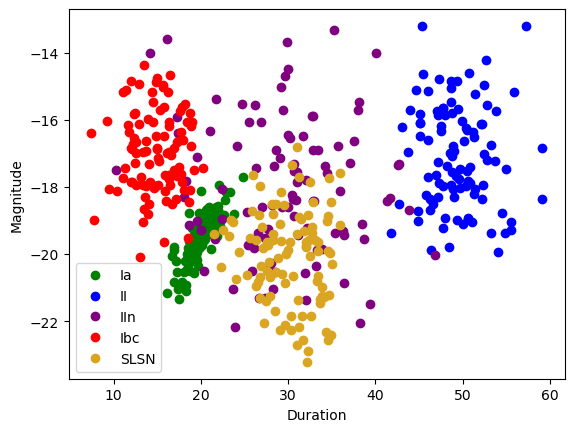

In [163]:
# Make a fake population, using peak luminosity and duration to classify
# Note -- this is just a toy example! Please don't take values literally!!
ia_features = multivariate_normal.rvs(mean=[20,-19.5], cov=[[3,1],[1,0.5]], size=100)
ii_features = multivariate_normal.rvs(mean=[50,-17], cov=[10,2], size=100)
iin_features = multivariate_normal.rvs(mean=[30,-18], cov=[50,5], size=100)
ibc_features = multivariate_normal.rvs(mean=[15,-17], cov=[10,2], size=100)
slsn_features = multivariate_normal.rvs(mean=[30,-20], cov=[10,2], size=100)

plt.plot(ia_features[:,0],ia_features[:,1],'o',color='green',label='Ia')
plt.plot(ii_features[:,0],ii_features[:,1],'o',color='blue',label='II')
plt.plot(iin_features[:,0],iin_features[:,1],'o',color='purple',label='IIn')
plt.plot(ibc_features[:,0],ibc_features[:,1],'o',color='red',label='Ibc')
plt.plot(slsn_features[:,0],slsn_features[:,1],'o',color='goldenrod',label='SLSN')

plt.xlabel('Duration')
plt.ylabel('Magnitude')
plt.legend()

# I am also going to go ahead and make our training/test set by adding labels to each set of features
labels = np.repeat(['Ia', 'II','IIn','Ibc','SLSN'], 100)
labels_new = [y_dict[x] for x in labels]
all_features = np.vstack((ia_features, ii_features, iin_features, ibc_features, slsn_features))
print(np.shape(all_features))
X_train, X_test, y_train, y_test = train_test_split(all_features, labels_new, test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [164]:
def custom_hier_loss(output, target, layers):
	final_sum = 0
	alpha = 1.0
	new_output = torch.zeros(torch.Tensor.size(output))
	#print('original',output[0])
	new_output[:, 0] = 1.0
	new_output[:,1:3] = torch.nn.functional.softmax(output[:,1:3],dim=1)
	new_output[:,3:5] = torch.nn.functional.softmax(output[:,3:5],dim=1)
	new_output[:,5:7] = torch.nn.functional.softmax(output[:,5:7],dim=1)
	new_output[:,7:9] = torch.nn.functional.softmax(output[:,7:9],dim=1)
	output = new_output

	output_log = output.log()
	new_output2 = torch.zeros(torch.Tensor.size(output))
	new_output2[:,1:3] = output_log[:,1:3] * np.exp(-alpha * 0.0)
	new_output2[:,3:5] = output_log[:,3:5] * np.exp(-alpha * 1.0)
	new_output2[:,5:7] = output_log[:,5:7]* np.exp(-alpha * 2.0)
	new_output2[:,7:9] = output_log[:,7:9]*np.exp(-alpha * 2.0)
	output = new_output2
	final_sum = ((output*target).sum(dim=1)).mean()
	return -final_sum#/len(target)

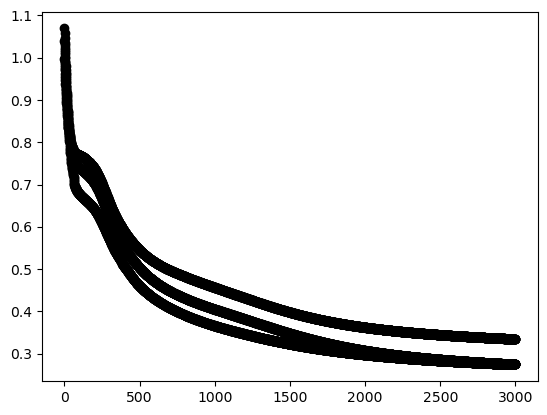

In [208]:

model = Feedforward(np.shape(X_test[0])[0], 5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
model.train()
epoch = 3000
n_batches = 128

for epoch in range(epoch):
    for i in range(int(len(X_train)/n_batches)+1):
        # Local batches and labels
        local_X, local_y = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,]
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(local_X)
        #y_res_pred = model(X_res[0:20])
        # Compute Loss
        loss = custom_hier_loss(y_pred.to(torch.float),local_y.to(torch.float),A)
        # Backward pass
        loss.backward()
        optimizer.step()
        plt.plot(epoch,loss.detach().numpy(),'ko')
    #scheduler.step()
plt.show()

In [209]:
model.eval()
y_pred = model(X_test)
print(y_pred)

tensor([[ 0.2246, -2.8208,  2.6612,  ..., -3.3228, -5.2584,  5.4430],
        [ 0.3223,  0.7319, -0.5506,  ..., -1.6011, -7.2000,  7.1687],
        [ 0.1808, -2.3304,  2.2802,  ..., -1.7889, -4.7442,  4.9445],
        ...,
        [ 0.0874, -1.3804,  1.5227,  ...,  1.2826, -3.8629,  4.0327],
        [ 0.2458,  0.1352,  0.0434,  ..., -0.6009, -6.1845,  6.2103],
        [ 0.0783, -1.4890,  1.6268,  ...,  1.3718, -3.7158,  3.8963]],
       grad_fn=<AddmmBackward0>)


In [210]:
truths = []
results = []
truths_ia = []
results_ia = []
ia_probs = []
truths_stripped = []
results_stripped = []
for i,thing in enumerate(y_test):
    probs = y_pred[i].squeeze()
    ia_prob = torch.nn.functional.softmax(probs[1:3],dim=0)[0]
    type_ii_prob = (1.0 - ia_prob) * torch.nn.functional.softmax(probs[3:5],dim=0)[1]
    ii_prob = type_ii_prob * torch.nn.functional.softmax(probs[7:9],dim=0)[0]
    iin_prob = type_ii_prob * torch.nn.functional.softmax(probs[7:9],dim=0)[1]
    type_i_prob = (1.0 - ia_prob) * torch.nn.functional.softmax(probs[3:5],dim=0)[0]

    ibc_prob = type_i_prob * torch.nn.functional.softmax(probs[5:7],dim=0)[0]
    slsn_prob = type_i_prob * torch.nn.functional.softmax(probs[5:7],dim=0)[1]
    if torch.all(y_test[i] == torch.tensor([1,1,0,0,0,0,0,0,0])):
        my_true_type = 'Ia'
        my_truth_ia = 'Ia'
        my_truth_stripped = 'Ia'
    elif torch.all(y_test[i] == torch.tensor([1,0,1,0,1,0,0,1,0])):
        my_true_type = 'II'
        my_truth_ia = 'CC'
        my_truth_stripped = 'II'

    elif torch.all(y_test[i] == torch.tensor([1,0,1,1,0,1,0,0,0])):
        my_true_type = 'Ibc'
        my_truth_ia = 'CC'
        my_truth_stripped = 'Ibc'
    elif torch.all(y_test[i] == torch.tensor([1,0,1,0,1,0,0,0,1])):
        my_true_type = 'IIn'
        my_truth_ia = 'CC'
        my_truth_stripped = 'II'
    else:
        my_true_type = 'SLSN'
        my_truth_ia = 'CC'
        my_truth_stripped = 'Ibc'

    truths.append(my_true_type)
    truths_ia.append(my_truth_ia)
    truths_stripped.append(my_truth_stripped)
    all_probs = np.asarray([slsn_prob.detach(),ii_prob.detach(),iin_prob.detach(),ia_prob.detach(),ibc_prob.detach()])
    max_prob = np.argmax(all_probs)
    results.append(sne_list[max_prob])
    if ia_prob>=0.5:
        results_ia.append('Ia')
    else:
        results_ia.append('CC')
    if results[-1] == 'Ia':
        results_stripped.append('Ia')
    elif (results[-1]=='Ibc') or (results[-1]=='SLSN'):
        results_stripped.append('Ibc')
    else:
        results_stripped.append('II')
    #print(my_true_type,*probs.detach().numpy())

print(confusion_matrix(truths, results,labels=sne_list,normalize='true'))
print(confusion_matrix(truths_ia, results_ia,labels=['Ia','CC'],normalize='true'))
print(confusion_matrix(truths_stripped, results_stripped,labels=['Ia','II','Ibc'],normalize='true'))


[[0.77142857 0.         0.2        0.02857143 0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.2962963  0.         0.51851852 0.14814815 0.03703704]
 [0.04444444 0.         0.         0.93333333 0.02222222]
 [0.         0.         0.         0.         1.        ]]
[[0.75555556 0.24444444]
 [0.04166667 0.95833333]]
[[0.93333333 0.         0.06666667]
 [0.07692308 0.75       0.17307692]
 [0.01470588 0.10294118 0.88235294]]


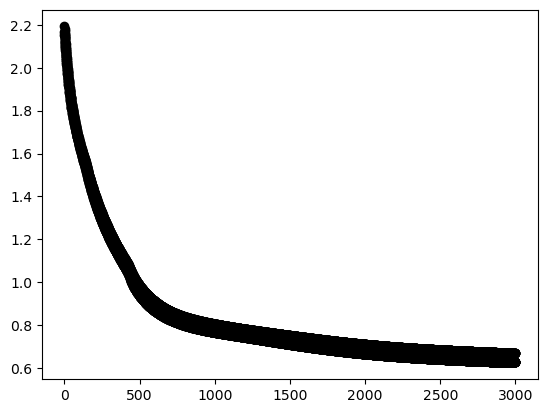

In [223]:

labels = np.repeat(['Ia', 'II','IIn','Ibc','SLSN'], 100)
le = preprocessing.LabelEncoder()
le.fit(labels)
new_labels = le.transform(labels)

all_features = np.vstack((ia_features, ii_features, iin_features, ibc_features, slsn_features))
X_train, X_test, y_train, y_test = train_test_split(all_features, new_labels, test_size=0.33, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


model = Feedforward(np.shape(X_test[0])[0], 5)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
model.train()
epoch = 3000
n_batches = 128
cross_entropy_loss = torch.nn.CrossEntropyLoss()

for epoch in range(epoch):
    for i in range(int(len(X_train)/n_batches)+1):
        # Local batches and labels
        local_X, local_y = X_train[i*n_batches:(i+1)*n_batches,], y_train[i*n_batches:(i+1)*n_batches,]
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(local_X)
        #y_res_pred = model(X_res[0:20])
        # Compute Loss
        loss = cross_entropy_loss(y_pred, local_y.long())
        # Backward pass
        loss.backward()
        optimizer.step()
        plt.plot(epoch,loss.detach().numpy(),'ko')
    #scheduler.step()
plt.show()

In [242]:
truths = []
results = []
truths_ia = []
results_ia = []
ia_probs = []
truths_stripped = []
results_stripped = []
y_pred = model(X_test)
for i,thing in enumerate(y_test):
    probs = y_pred[i].squeeze()
    result = le.inverse_transform([int(np.argmax(probs.detach().numpy()))])
    sn_true_type = le.inverse_transform([int(thing.detach().numpy())])
    my_true_type = sn_true_type
    if sn_true_type == 'Ia':
        my_truth_ia = 'Ia'
        my_truth_stripped = 'Ia'
    else:
        my_truth_ia = 'CC'
    if (sn_true_type == 'Ibc') or (sn_true_type == 'SLSN'):
        my_truth_stripped = 'Ibc'
    elif (sn_true_type == 'II') or (sn_true_type == 'IIn'):
        my_truth_stripped = 'II'
    truths.append(sn_true_type)
    truths_ia.append(my_truth_ia)
    truths_stripped.append(my_truth_stripped)
    results.append(result)
    if result == 'Ia':
        results_ia.append('Ia')
        results_stripped.append('Ia')
    else:
        results_ia.append('CC')
    if (result == 'Ibc') or (result == 'SLSN'):
        results_stripped.append('Ibc')
    elif (result == 'II') or (result == 'IIn'):
        results_stripped.append('II')
    


print(confusion_matrix(truths, results,labels=sne_list,normalize='true'))
print(confusion_matrix(truths_ia, results_ia,labels=['Ia','CC'],normalize='true'))
print(confusion_matrix(truths_stripped, results_stripped,labels=['Ia','II','Ibc'],normalize='true'))


[[0.82857143 0.         0.14285714 0.02857143 0.        ]
 [0.         1.         0.         0.         0.        ]
 [0.51851852 0.         0.2962963  0.18518519 0.        ]
 [0.         0.         0.         0.77777778 0.22222222]
 [0.         0.         0.         0.24242424 0.75757576]]
[[0.77777778 0.22222222]
 [0.11666667 0.88333333]]
[[0.77777778 0.         0.22222222]
 [0.09615385 0.63461538 0.26923077]
 [0.13235294 0.07352941 0.79411765]]
